<a href="https://colab.research.google.com/github/lorenzkuhn/advi/blob/main/ARD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip3 install pyro-ppl 

     |████████████████████████████████| 718 kB 4.7 MB/s 
     |████████████████████████████████| 750.6 MB 11 kB/s 
  Attempting uninstall: torch
    Found existing installation: torch 1.10.0+cu111
    Uninstalling torch-1.10.0+cu111:
      Successfully uninstalled torch-1.10.0+cu111
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchvision 0.11.1+cu111 requires torch==1.10.0, but you have torch 1.11.0 which is incompatible.
torchtext 0.11.0 requires torch==1.10.0, but you have torch 1.11.0 which is incompatible.
torchaudio 0.10.0+cu111 requires torch==1.10.0, but you have torch 1.11.0 which is incompatible.


In [144]:
import torch
from torch import nn

import pyro
from pyro.nn import PyroModule
from pyro.nn import PyroSample
from pyro.infer import MCMC, NUTS, HMC, Predictive
from pyro.infer.autoguide import AutoDiagonalNormal
from pyro.infer.autoguide import AutoContinuous
from pyro.infer import SVI, Trace_ELBO
import pyro.distributions as dist
from torch.distributions import constraints

import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import time

In [198]:
# Making training data
# Adopted from https://github.com/julianroth/ADVI/blob/master/ard_experiment.py

def make_training_data(num_samples, dims, sigma, mu=0):
  """
  Creates training data when half of the regressors are 0
  """
  x = np.random.randn(num_samples, dims).astype(np.float64)
  w = sigma * np.random.randn(1,dims).astype(np.float64)
  noise = np.random.normal(0, 5, num_samples).astype(np.float64).reshape(-1,1)
  #noise = 0
  w[:,:int(dims/2)] = 0.
  y = np.matmul(x, w.T) + (noise/2) + mu

  y = torch.tensor(y, dtype = torch.float)
  x = torch.tensor(x, dtype = torch.float)
  return y, x, w


def sep_training_test(y,x,test):
  y_train = y[test:,:]
  x_train = x[test:,:]
  
  y_test = y[:test,:]
  x_test = x[:test,:]
  return y_train, y_test, x_train, x_test

num_features = 250

y, x, w = make_training_data(11000, num_features, 10, mu=0)
y_train, y_test, x_train, x_test = sep_training_test(y,x,1000)

In [200]:
# Define the bayesian model in pyro
def model(x, y=None):
      num_features = x.shape[1]

      alpha = pyro.sample('alpha', dist.Gamma(torch.tensor([1.0]), torch.tensor([1.0])).expand([num_features]).to_event(1))
      one_over_sqrt_alpha = 1/torch.sqrt(alpha)

      sigma2 = pyro.sample('sigma2', dist.InverseGamma(torch.tensor([1.0]), torch.tensor([1.0])))
      sigma = torch.sqrt(sigma2)

      beta = pyro.sample('beta', dist.Normal(torch.tensor([0.0]), sigma*one_over_sqrt_alpha).expand([num_features]).to_event(1))

      mean = torch.matmul(x, beta)

      with pyro.plate("data", x.shape[0]):          
          outcome_dist = dist.Normal(mean, sigma)          
          observation = pyro.sample("obs", outcome_dist, obs=y)

In [201]:
# Define the ADVI components: Guide, Optimizer and SVI
torch.manual_seed(0)

guide = AutoDiagonalNormal(model)
adaprop = pyro.optim.AdagradRMSProp(dict())
svi = SVI(model, guide, adaprop, loss=Trace_ELBO())

# Run ADVI 
pyro.clear_param_store()

output_advi = pd.DataFrame(columns = ["t", "test_accuracy", "model"])

num_iterations = 10000
step_ids = []
step_time = []
average_log_predictives = []
mse_loss = nn.MSELoss()
train_time = 0

sample_size_l = np.arange(1500, 20000, 1000)
sample_size_s = np.arange(0, 1500, 100)
sample_size = np.concatenate((sample_size_s, sample_size_l))


for j in range(num_iterations):
    # calculate the loss and take a gradient step
    t0 = time.time()
    loss = svi.step(x_train, y_train.squeeze())
    t1 = time.time()
    train_time += (t1-t0)     

    if j in sample_size: #Evaluate model every 1000 samples
      learned_beta = guide.median()['beta']
      learned_sigma2 = guide.median()['sigma2']

      mean = torch.matmul(x_test, learned_beta)
      sigma = torch.sqrt(learned_sigma2)

      norm_dist = dist.Normal(mean, sigma)
      test_log_prob = norm_dist.log_prob(y_test.squeeze()).sum()
      test_log_prob /= len(y_test)

      output_iter = {"t":train_time,
                    "test_accuracy":test_log_prob.detach().numpy(),
                    "model":"advi"}

      output_advi = output_advi.append(output_iter, ignore_index = True)
      print("[iteration %04d] loss: %.4f" % (j + 1, test_log_prob))

[iteration 0001] loss: -1103.4833
[iteration 0101] loss: -12.3408
[iteration 0201] loss: -4.9245
[iteration 0301] loss: -3.7205
[iteration 0401] loss: -2.3921
[iteration 0501] loss: -2.3762
[iteration 0601] loss: -2.3698
[iteration 0701] loss: -2.3682
[iteration 0801] loss: -2.3608
[iteration 0901] loss: -2.3688
[iteration 1001] loss: -2.3728
[iteration 1101] loss: -2.3672
[iteration 1201] loss: -2.3675
[iteration 1301] loss: -2.3552
[iteration 1401] loss: -2.3587
[iteration 1501] loss: -2.3657
[iteration 2501] loss: -2.3628
[iteration 3501] loss: -2.3621
[iteration 4501] loss: -2.3639
[iteration 5501] loss: -2.3627
[iteration 6501] loss: -2.3603
[iteration 7501] loss: -2.3581
[iteration 8501] loss: -2.3584
[iteration 9501] loss: -2.3612


In [202]:
# Run MCMC using Stan kernel
pyro.clear_param_store()
torch.manual_seed(0)

test_log_prob_list = []
train_time = []

def hook_fn(kernel, sample, stage, i):
    #use the most recently sampled param to estimate performance
    if i < 100 or (i % 50 == 0): #evaluate all first 100 samples and then every 50
      learned_beta = sample['beta']
      learned_sigma2 = torch.exp(sample['sigma2']) #ATTENTION: InvGamma uses PowerTransform
      
      mean = torch.matmul(x_test, learned_beta)
      sigma = torch.sqrt(learned_sigma2)

      norm_dist = dist.Normal(mean, sigma)
      test_log_prob = torch.sum(norm_dist.log_prob(y_test.squeeze()))
      test_log_prob /= len(y_test)

      train_time.append(time.time())    
      test_log_prob_list.append(test_log_prob)

nuts_kernel = NUTS(model, max_tree_depth = 4)

nuts = MCMC(
            nuts_kernel,
            num_samples=300,
            warmup_steps=300,
            disable_progbar=False,
            num_chains = 1,
            hook_fn = hook_fn
    ) 

nuts.run(x_train, y_train.squeeze())

output_nuts = pd.DataFrame({'t':np.array(train_time)-train_time[0], 
                            "test_accuracy":np.array(test_log_prob_list),
                            "model":"nuts"})

Sample: 100%|██████████| 600/600 [00:48, 12.38it/s, step size=3.26e-01, acc. prob=0.863]


Warmup:   4%|▍         | 24/600 [10:49, 27.06s/it, step size=1.72e-03, acc. prob=0.785]


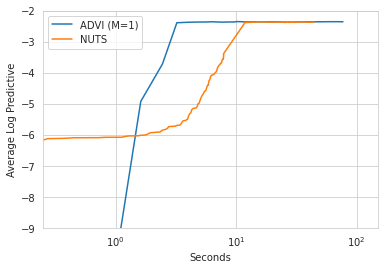

In [206]:
# Generate plot (Figure 4 in original paper)

output = output_advi.append(output_nuts, ignore_index=True)
output = output.loc[output['t'] < 100]
output['test_accuracy'] = output['test_accuracy'].astype('float')

sns.set_style("whitegrid")
results = sns.lineplot(data = output, x = 't', y = 'test_accuracy', hue = 'model')
results.set(xscale='log', 
            xlim = (0.25, 150), 
            ylim = (-9, -2),
            xlabel = 'Seconds',
            ylabel = 'Average Log Predictive')
plt.legend(labels=["ADVI (M=1)","NUTS"])